In [56]:
import sys
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random
from typing import Tuple, Union

In [57]:
sys.path.append("../src/")

from metrics import mae, rmse, smape, print_metrics
from network import Network
from utils import (
    plot_error_prediction,
    plot_absolute_error,
    plot_absolute_error_histogram,
    plot_average_error,
    plot_distance_and_error,
    plot_neurons,
)


## Read Data Set


In [81]:

train_df = pd.read_csv("../data/train_data_200cm.csv")
test_df  = pd.read_csv("../data/test_data_200cm.csv")

x_train = train_df.drop("object_distance", axis=1).values.astype(np.float32)
y_train = train_df["object_distance"].values.astype(np.float32)

x_test = test_df.drop("object_distance", axis=1).values.astype(np.float32)
y_test = test_df["object_distance"].values.astype(np.float32)

## Analysis of initial nodes

100%|██████████| 600/600 [00:02<00:00, 288.02it/s]


MAE minimo: 4.967283084988594 Cm en 73 
RMSEminimo: 11.951775848865509 Cm en 73
SMAPE minimo: 7.148058712482452 % en 72


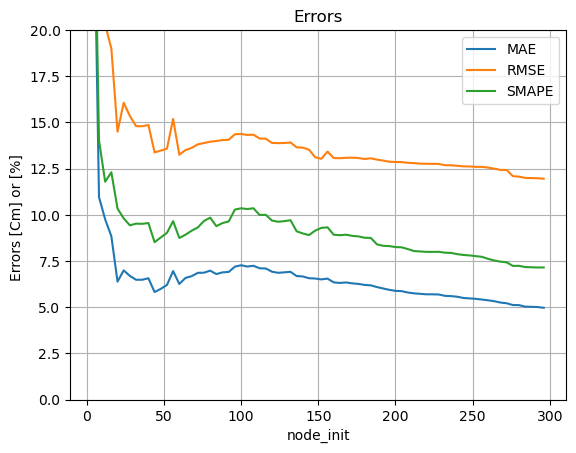

In [59]:


nodes_init = []
mae_a = []
rmse_a = []
smape_a = []

num_values = x_train.shape[1]
scope = 200

for i in range (1,75):
    node_nodes = max(1,num_values*i * 0.01)
    nodes_init.append(node_nodes)
    net = Network(input_size=num_values,output_size=1, average_window=1000)          # Number of input components (num_values)
    net.init_with_kmeans(x_train, y_train, n_nodes=int(node_nodes))
    y_pred_test = np.zeros_like(y_test) 

# Paso 2: Aprendizaje en línea en el conjunto de prueba con probabilidad baja
    for i, (x, y_true) in tqdm(enumerate(zip(x_test, y_test)), total=len(x_test)):
        y_pred_test[i] = net.inference(x)[0]

    mae_a.append(mae(y_test,y_pred_test,scope=scope))
    rmse_a.append(rmse(y_test,y_pred_test,scope=scope))
    smape_a.append(smape(y_test,y_pred_test))

min_value_mae = min(mae_a)
min_index_mae = mae_a.index(min_value_mae)  # Encuentra el índice del valor mínimo

min_value_rmse = min(rmse_a)
min_index_rmse = rmse_a.index(min_value_rmse)

min_value_smape = min(smape_a)
min_index_smape = smape_a.index(min_value_smape)

print(f"MAE minimo: {min_value_mae} Cm en {min_index_mae} ")
print(f"RMSEminimo: {min_value_rmse} Cm en {min_index_rmse}")
print(f"SMAPE minimo: {min_value_smape} % en {min_index_smape}")

plt.plot(nodes_init, mae_a, label='MAE')
plt.plot(nodes_init, rmse_a, label='RMSE')
plt.plot(nodes_init, smape_a, label='SMAPE')
plt.xlabel('node_init')
plt.ylabel('Errors [Cm] or [%] ')
plt.title('Errors')
plt.legend()
plt.grid()
plt.ylim(0,20)
plt.show()



## Analysis without online training

100%|██████████| 1500/1500 [00:01<00:00, 874.22it/s] 


=== Métricas en Datos de Prueba (después del aprendizaje en línea) ===
MAE: 8.5603 Cm
RMSE: 15.0480 Cm
SMAPE: 0.0426 %
Numero de nodos: 72


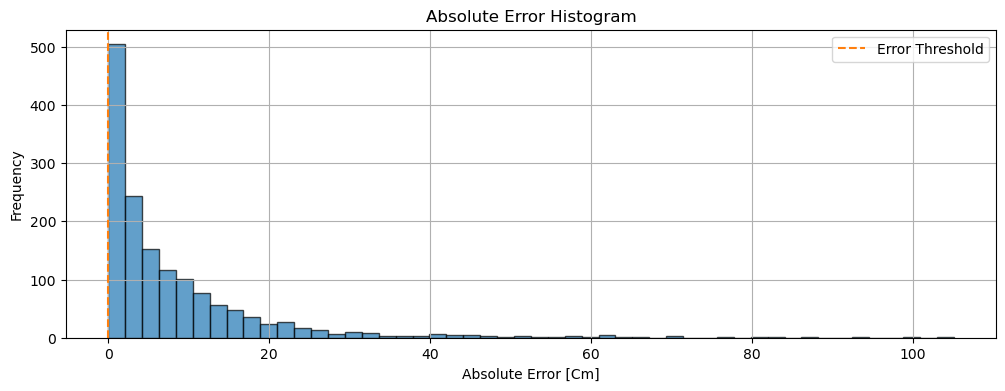

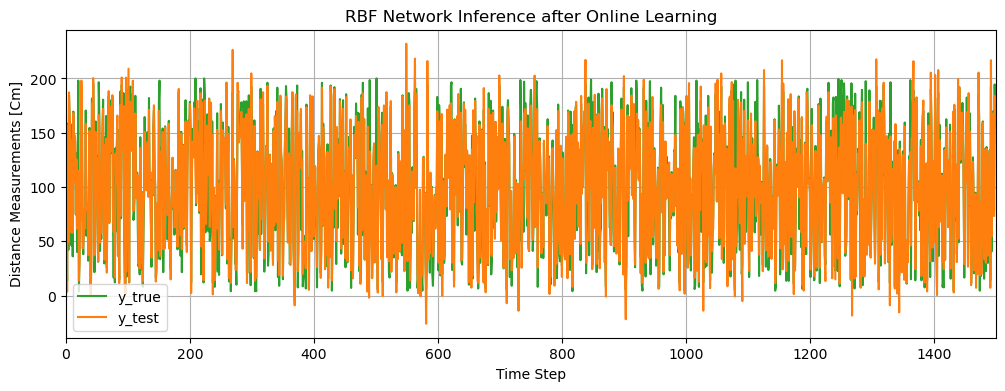

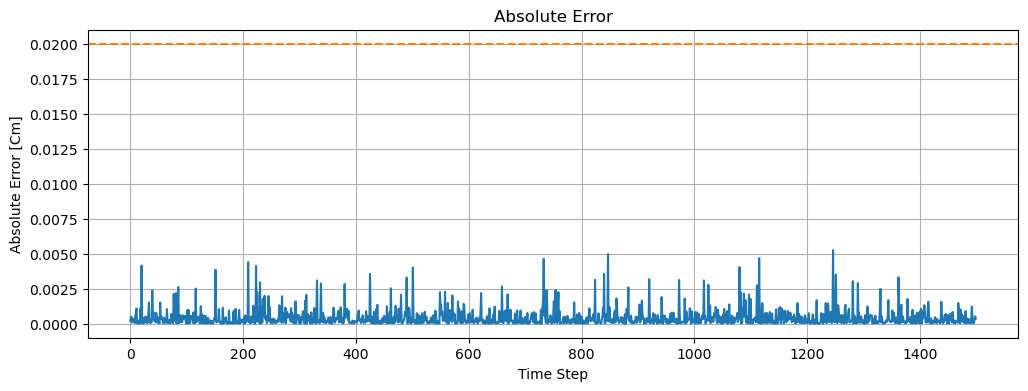

In [82]:

net.init_with_kmeans(x_train, y_train, n_nodes=int(72))
# Inicializa las matrices de estadísticas para entrenamiento y prueba
stats_train = np.zeros((len(x_train), 5))
stats_test = np.zeros((len(x_test), 5))

# Inference on the test set
y_pred_test = np.zeros_like(y_test)

# Paso 2: Aprendizaje en línea en el conjunto de prueba con probabilidad baja
for i, (x, y_true) in tqdm(enumerate(zip(x_test, y_test)), total=len(x_test)):
    
    y_pred_test[i] = net.inference(x)[0]
    distances = [np.linalg.norm(x - node.center) for node in net._hidden_nodes]
    stats_test[i, 0] = np.min(distances)           # Distancia al nodo más cercano
    stats_test[i, 1] = np.linalg.norm(y_true - y_pred_test[i])  # Error de predicción
    stats_test[i, 2] = net._d_th                       # Umbral de distancia
    stats_test[i, 3] = net._e_th                       # Umbral de error
    stats_test[i, 4] = len(net._hidden_nodes)          # Número de neuronas ocultas

# Métricas después del aprendizaje en línea
print("=== Métricas en Datos de Prueba (después del aprendizaje en línea) ===")
print_metrics(y_test, y_pred_test,scope=scope)
print(f"Numero de nodos: {72}")
plot_absolute_error_histogram(y_test, y_pred_test,scope=scope,error_threshold=net._e_th)
# Visualización de resultados
plot_error_prediction(y_test, y_pred_test,scope=scope, title="RBF Network Inference after Online Learning")
plot_absolute_error(y_test, y_pred_test, net._e_th)



In [83]:
with open("net_pretrained.pickle", "wb") as f:
    pickle.dump(net, f)

## Analysis with online training


## Hyperparameter Optimization Process

### `Hyperparameter Grid Search`

Performs an exhaustive search over predefined hyperparameter combinations to find the optimal configuration.

**Hyperparameters Explored:**
- `learning_rates`: List of learning rate values to test.
- `error_thresholds`: Acceptable error margins for optimization.
- `overlap_factors`: Overlap factors in network configuration.
- `average_windows`: Sizes of averaging windows for filtering.
- `activation_ths`: Activation thresholds for neuron activation.
- `pruning_windows`: Windows for pruning redundant neurons.

**Process:**
1. Iterates through all possible hyperparameter combinations.
2. Initializes the `Network` model with the current set of hyperparameters.
3. Trains the model using KMeans initialization and dataset split.
4. Performs inference on test data.
5. Computes performance metrics:
   - `MAE` (Mean Absolute Error)
   - `RMSE` (Root Mean Square Error)
   - `SMAPE` (Symmetric Mean Absolute Percentage Error)
6. Records results in a DataFrame.
7. Identifies the best configuration based on the lowest MAE.
8. Saves the best-found hyperparameter configuration in a JSON file.

**Returns:**
- `results_df`: DataFrame containing all tested configurations and their respective performance metrics.
- `best_config`: Optimal hyperparameter set with the lowest MAE.
- Saves `best_hyperparameters.json` with the best parameter values for future use.



In [35]:
results = []  # Lista para almacenar los resultados

# Definir listas de valores para cada hiperparámetro
learning_rates    = [0.1, 0.2, 0.3]
error_thresholds  = [0.005, 0.01, 0.02, 0.05]
overlap_factors   = [0.5, 0.8, 1.0]
average_windows   = [500, 1000]
activation_ths    = [0.005, 0.01]
pruning_windows   = [5, 10]

# Loops anidados para recorrer todas las combinaciones
for lr in learning_rates:
    for e_th in error_thresholds:
        for ov in overlap_factors:
            for avg_w in average_windows:
                for act_th in activation_ths:
                    for pr_w in pruning_windows:
                        # Inicializa la red con los hiperparámetros actuales y con el número óptimo de nodos
                        net = Network(input_size=num_values, output_size=1,
                                      error_threshold=e_th,
                                      learning_rate=lr,
                                      overlap_factor=ov,
                                      average_window=avg_w,
                                      activation_threshold=act_th,
                                      pruning_window=pr_w)
                        
                        net.init_with_kmeans(x_train, y_train, n_nodes=int(min_index_mae))
                        
                        # Realiza la inferencia en el set de prueba
                        y_pred_test = np.zeros_like(y_test)
                        for i, (x, y_true) in enumerate(zip(x_test, y_test)):
                            y_pred_test[i] = net.inference(x)[0]
                        
                        # Calcula las métricas
                        current_mae   = mae(y_test, y_pred_test)
                        current_rmse  = rmse(y_test, y_pred_test)
                        current_smape = smape(y_test, y_pred_test)
                        
                        # Guarda la combinación y sus métricas
                        results.append({
                            "lr": lr,
                            "e_th": e_th,
                            "overlap": ov,
                            "avg_w": avg_w,
                            "k": k,
                            "act_th": act_th,
                            "pr_w": pr_w,
                            "mae": current_mae,
                            "rmse": current_rmse,
                            "smape": current_smape
                        })

# Convertir la lista de resultados en un DataFrame para su análisis
results_df = pd.DataFrame(results)
print(results_df.sort_values("mae"))



      lr   e_th  overlap  avg_w    k  act_th  pr_w       mae      rmse  \
29   0.1  0.010      0.5   1000  2.0   0.005    10  0.012556  0.019679   
158  0.2  0.020      0.8   1000  2.0   0.010     5  0.012556  0.019679   
272  0.3  0.050      0.8    500  2.0   0.005     5  0.012556  0.019679   
258  0.3  0.020      1.0    500  2.0   0.010     5  0.012556  0.019679   
168  0.2  0.050      0.5    500  2.0   0.005     5  0.012556  0.019679   
..   ...    ...      ...    ...  ...     ...   ...       ...       ...   
217  0.3  0.010      0.5    500  2.0   0.005    10  0.012556  0.019679   
234  0.3  0.010      1.0    500  2.0   0.010     5  0.012556  0.019679   
130  0.2  0.010      0.8    500  2.0   0.010     5  0.012556  0.019679   
196  0.3  0.005      0.5   1000  2.0   0.005     5  0.012556  0.019679   
256  0.3  0.020      1.0    500  2.0   0.005     5  0.012556  0.019679   

        smape  
29   2.030532  
158  2.030532  
272  2.030532  
258  2.030532  
168  2.030532  
..        ...  

In [36]:
# Supongamos que 'results_df' es tu DataFrame con todas las combinaciones y sus métricas.
# Seleccionar la fila con el menor MAE:
best_config = results_df.loc[results_df['mae'].idxmin()]

print("Mejores hiperparámetros encontrados:")
print(best_config)

# Extraer cada hiperparámetro
best_values = {
    "lr": best_config['lr'],
    "e_th": best_config['e_th'],
    "overlap": best_config['overlap'],
    "avg_w": best_config['avg_w'],
    "k": best_config['k'],
    "act_th": best_config['act_th'],
    "pr_w": best_config['pr_w']
}

# Guardar la configuración en un archivo JSON para usarla posteriormente
import json
with open("best_hyperparameters.json", "w") as f:
    json.dump(best_values, f, indent=4)


Mejores hiperparámetros encontrados:
lr            0.100000
e_th          0.010000
overlap       0.500000
avg_w      1000.000000
k             2.000000
act_th        0.005000
pr_w         10.000000
mae           0.012556
rmse          0.019679
smape         2.030532
Name: 29, dtype: float64



### Experimentation with Pretrained Model

Performs real-time experimentation with a pre-trained network model to assess neuron evolution and performance with varying reference availability.

**Process:**
1. Loads a pre-trained model.
2. Adjusts specific hyperparameters.
3. Evaluates the model in online learning mode, recording neuron evolution.
4. Computes overall statistical metrics per reference availability.
5. Aggregates results and visualizes performance trends.
6. Saves statistical results to a pickle file for analysis.

**Returns:**
- `stats`: DataFrame containing statistics of neuron usage and performance metrics.
- `agg_stats`: Aggregated results for visualization and further analysis.
- Generates graphical plots for neuron usage and error metrics.


100%|██████████| 8/8 [00:13<00:00,  1.64s/it]


  t_ref max_neurons mean_neurons   mean_mae  mean_rmse mean_smape
2   30s         197      127.534  13.892811  21.139471  23.480026
6    5m          72    62.262667  14.055724  21.639403  23.315669
5   50m          72       70.764   8.776484  15.107919  17.965613
3    3h          72         72.0   8.569565  15.055834  17.614676
7    6h          72         72.0   8.663295  15.056971  18.058665
0   12h          72         72.0   8.663295  15.056971  18.058665
1   24h          72         72.0   8.560303   15.04805  17.691857
4   48h          72         72.0   8.560303   15.04805  17.691857


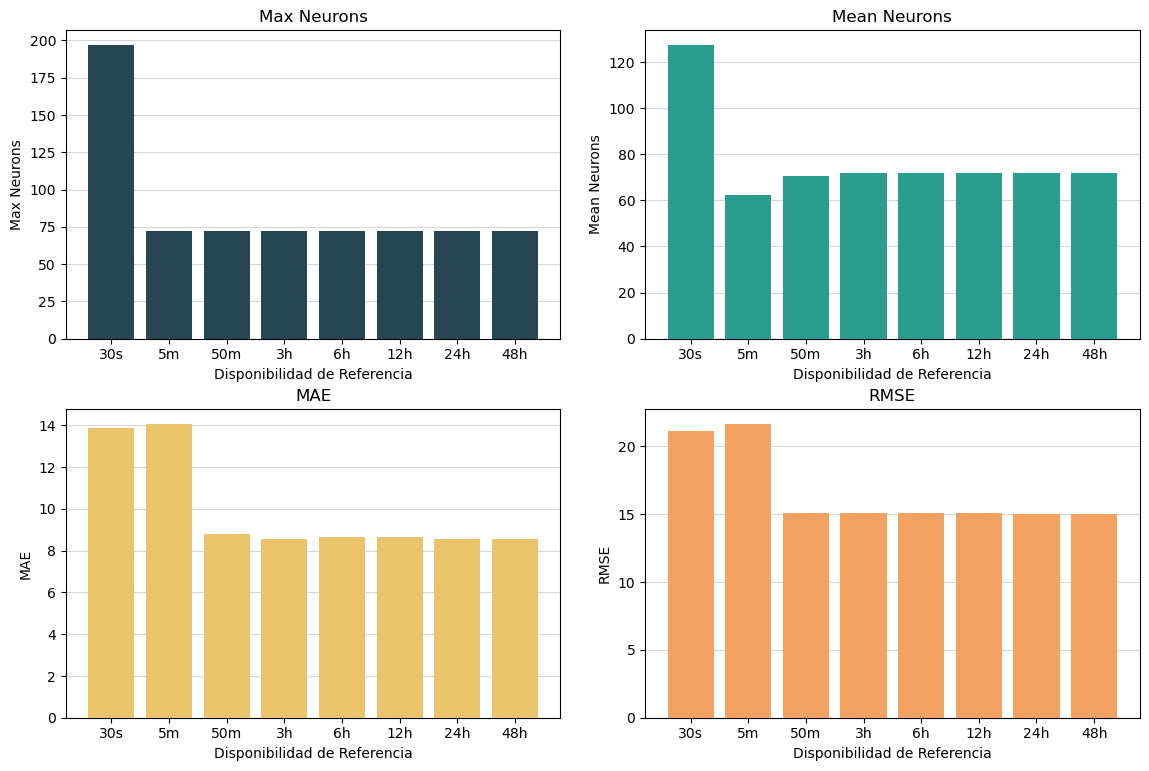

In [91]:
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

# Funciones de métricas (asegúrate de definirlas o importarlas)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

# Cargar datos desde los CSV de entrenamiento y prueba
train_df = pd.read_csv("../data/train_data_200cm.csv")
test_df  = pd.read_csv("../data/test_data_200cm.csv")

# Suponemos que las columnas de x son todas las que comienzan con 'distance_bin_'
cols = [col for col in train_df.columns if col.startswith("distance_bin_")]

x_train = train_df[cols].to_numpy()
y_train = train_df["object_distance"].to_numpy()

x_test  = test_df[cols].to_numpy()
yhat_test = test_df["object_distance"].to_numpy()  # valor real
y_test  = np.zeros_like(yhat_test)  # para almacenar las predicciones

# Definir distintos p_ref y sus etiquetas (disponibilidad de referencia)
p_refs = {
    1.0:           "30s",
    0.1:           "5m",
    0.01:          "50m",
    0.002777778:   "3h",
    0.001388889:   "6h",
    0.000694444:   "12h",
    0.000347222:   "24h",
    0.000173611:   "48h",
}

# Semillas para reproducibilidad
seeds = [42]

# DataFrame para acumular las estadísticas del experimento
stats = pd.DataFrame(
    columns=[
        "t_ref",
        "seed",
        "max_neurons",
        "mean_neurons",
        "mean_mae",
        "mean_rmse",
        "mean_smape",
    ],
    index=range(len(p_refs) * len(seeds))
)

experiment = 0
for (p_ref, label) in tqdm(p_refs.items(), total=len(p_refs)):
    for seed in seeds:
        # Cargar el modelo pre-entrenado (ajusta la ruta y el nombre según corresponda)
        with open("net_pretrained.pickle", "rb") as f:
            net = pickle.load(f)
        # Ajustar hiperparámetros según el segundo código
        net._avg_w   = 1000  # 12 horas
        net._overlap = 0.5
        net._e_th    = 0.01
        net._lr      = 0.1
        net._act_th  = 0.005
        net._pr_w    = 10

        # Opcional: Pre-entrenamiento con el set de entrenamiento
        # for x, y in zip(x_train, y_train):
        #     net.learning(x, np.array([y]))

        n_nodes = []  # Para registrar la evolución del número de neuronas
        random.seed(seed)
        # Aprendizaje en línea sobre el set de prueba
        for i, (x, yhat) in enumerate(zip(x_test, yhat_test)):
            if random.random() < p_ref:
                y_test[i] = net.learning(x, np.array([yhat]))[0]
            else:
                y_test[i] = net.inference(x)[0]
            n_nodes.append(len(net._hidden_nodes))

        # Calcular métricas
        max_neurons  = np.max(n_nodes)
        mean_neurons = np.mean(n_nodes)
        mae_val  = mae(yhat_test, y_test) * scope
        rmse_val = rmse(yhat_test, y_test) * scope
        smape_val = smape(yhat_test, y_test)

        stats.loc[experiment] = [label, seed, max_neurons, mean_neurons, mae_val, rmse_val, smape_val]
        experiment += 1

# Guardar las estadísticas y recargarlas (opcional)
stats.to_pickle("stats_ToF.pickle")
stats = pd.read_pickle("stats_ToF.pickle")

# Agregar estadísticas agrupadas según la disponibilidad de referencia
agg_stats = stats.groupby("t_ref", as_index=False).agg({
    "max_neurons": "max",
    "mean_neurons": "mean",
    "mean_mae": "mean",
    "mean_rmse": "mean",
    "mean_smape": "mean",
})
agg_stats.t_ref = agg_stats.t_ref.astype("category")
agg_stats.t_ref = agg_stats.t_ref.cat.set_categories(list(p_refs.values()))
agg_stats = agg_stats.sort_values("t_ref")
print(agg_stats)

# Graficar resultados: barras para las métricas
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout(pad=3.0)
colors = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261"]
columns = ["max_neurons", "mean_neurons", "mean_mae", "mean_rmse"]
xlabels = list(p_refs.values())
ylabels = ["Max Neurons", "Mean Neurons", "MAE", "RMSE"]
titles  = ["Max Neurons", "Mean Neurons", "MAE", "RMSE"]
x = np.arange(len(xlabels))

for i, ax in enumerate(axs.flat):
    ax.bar(x, agg_stats[columns[i]], color=colors[i], zorder=3)
    ax.set_ylabel(ylabels[i])
    ax.set_xlabel("Disponibilidad de Referencia")
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels)
    ax.set_title(titles[i])
    ax.grid(axis="y", alpha=0.5, zorder=0)
plt.show()


# Filter Pipeline for Object Position Extraction

**Objective:**  
Filter sensor signals to extract the object's position and compare it to the ground truth.

**Pipeline Steps:**
- **Filtering:**  
  - Subtract a fixed background noise value from the entire signal.  
  - Subtract a fixed crosstalk value from a defined index range (e.g., first half of the signal).

- **Position Extraction:**  
  - Find the index of the peak in the filtered signal.  
  - Map this index to a distance in meters (assuming a uniform distribution over 0 to 2 m).

- **Evaluation:**  
  - Compute MAE, RMSE, and SMAPE between the extracted positions and `y_test`.
  - Visualize the comparison with a plot.

**Key Parameters:**  
- `background_noise_value`  
- `crosstalk_range` (start and end indices)  
- `crosstalk_value`  
- `sensor_range` (e.g., 2.0 m)

**Core Functions:**  
- `aplicar_filtrado`: Applies both filters to the input signal.  
- `extraer_valor_objeto`: Returns the object’s position by mapping the peak index to distance.


MAE: 18.5865 Cm
RMSE: 29.4987 Cm
SMAPE: 0.0924 %


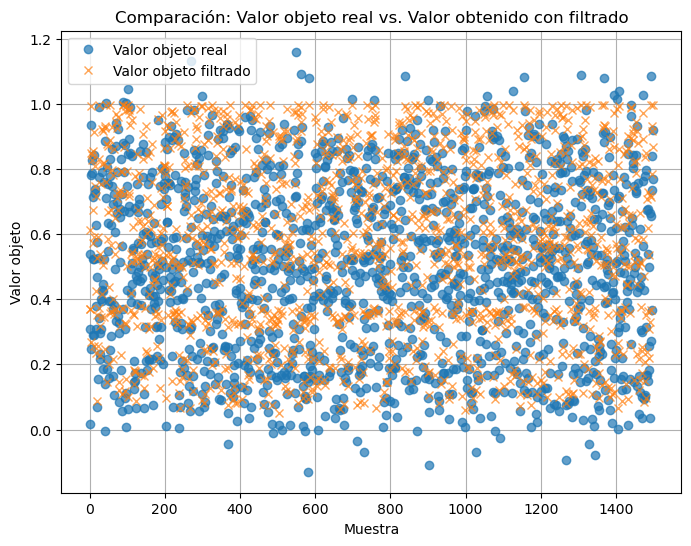

In [92]:
# %% Parámetros del filtrado
# Valor fijo a restar en toda la señal (ruido de fondo)
background_noise_value = 0.2  # Ajusta según la magnitud de tu ruido de fondo

# Parámetros para el filtro de crosstalk:
# Definir el rango (por índice) donde se aplica el filtrado y el valor a restar
crosstalk_range_start = 0                        # inicio del rango de crosstalk
crosstalk_range_end   = int(scope)   # se aplica en la primera mitad de la señal
crosstalk_value       = 1                     # valor a restar en ese rango

# %% Funciones del pipeline de filtrado

def aplicar_filtrado(signal, background_value, crosstalk_range, crosstalk_value):
    """
    Aplica dos filtros a la señal:
      - Resta un valor fijo a toda la señal (ruido de fondo).
      - En el rango definido (crosstalk_range), resta un valor fijo adicional.
    """
    # Copia la señal para evitar modificar el original
    signal_filtrada = signal.copy().astype(float)
    
    # Filtrado de ruido de fondo: resta el valor fijo a toda la señal
    signal_filtrada -= background_value
    
    # Filtrado de crosstalk: resta el valor fijo en la banda definida
    start, end = crosstalk_range
    signal_filtrada[start:end] -= crosstalk_value
    
    return signal_filtrada

def extraer_valor_objeto(signal_filtrada, method='peak', sensor_range=2.0):
    """
    Extrae la posición del objeto a partir de la señal filtrada.
    Se define:
      - method='peak': retorna la posición (en metros) correspondiente al índice donde se encuentra el pico máximo.
      - (Si se requiriera otro método, se podría implementar).
    
    Se asume que la señal tiene 'n_bins' muestras distribuidas uniformemente en el rango [0, sensor_range].
    """
    n_bins = len(signal_filtrada)
    if method == 'peak':
        peak_index = np.argmax(signal_filtrada)
        # Mapear el índice a distancia en metros (suponiendo distribución uniforme)
        position = peak_index * (sensor_range / n_bins)
        return position
    else:
        raise ValueError("El método debe ser 'peak'.")

# %% Aplicación del pipeline de filtrado en el conjunto de prueba

# Lista para almacenar la posición objeto extraída de cada señal filtrada
posiciones_objeto_filtrado = []

# Iterar sobre cada muestra de x_test (cada fila es una señal temporal)
for x in x_test:
    # Aplicar filtrado: se resta el ruido de fondo y luego el crosstalk en el rango definido
    signal_filtrada = aplicar_filtrado(x, background_noise_value, 
                                       (crosstalk_range_start, crosstalk_range_end), 
                                       crosstalk_value)
    # Extraer la posición del objeto usando el método 'peak'
    pos_objeto = extraer_valor_objeto(signal_filtrada, method='peak', sensor_range=1)
    posiciones_objeto_filtrado.append(pos_objeto)

# Convertir a array para facilitar el cálculo de métricas
posiciones_objeto_filtrado = np.array(posiciones_objeto_filtrado)


print_metrics(y_test, posiciones_objeto_filtrado,scope=scope)


# %% Comparación visual de los valores objeto
plt.figure(figsize=(8, 6))
plt.plot(y_test, label="Valor objeto real", marker='o', linestyle='None', alpha=0.7)
plt.plot(posiciones_objeto_filtrado, label="Valor objeto filtrado", marker='x', linestyle='None', alpha=0.7)
plt.xlabel("Muestra")
plt.ylabel("Valor objeto")
plt.title("Comparación: Valor objeto real vs. Valor obtenido con filtrado")
plt.legend()
plt.grid(True)
plt.show()




This notebook calculates the percentage change in mean MAE for different reference times relative to a baseline. 
- Negative values indicate improvements (lower error), while positive values indicate worsening performance (higher error). 
- This comparison helps evaluate model performance over various time intervals.


In [93]:
def improvement(new, old):
    return (new - old) / old * 100


baseline = 18.5865
for t_ref in ["30s", "5m", "50m", "3h", "6h", "12h", "24h", "48h"]:
    print(f"{t_ref}", end="")
    perc = improvement(
        stats.loc[stats["t_ref"] == t_ref, "mean_mae"].mean(),
        baseline,
    )
    print(f"\t{perc:.2f}%", end="")
    print()

30s	-25.25%
5m	-24.38%
50m	-52.78%
3h	-53.89%
6h	-53.39%
12h	-53.39%
24h	-53.94%
48h	-53.94%
